## Loading libraries

In [4]:
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urljoin
from tqdm import tqdm
from time import sleep
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

## Data Scraping

In [5]:
def get_data_and_next_page(response_text:str):
    start_idx = response_text.find('const data =') + len('const data =')
    end_idx = response_text.rfind(';', start_idx, response_text.find('const next ='))
    data_json = response_text[start_idx:end_idx].strip()
    data = json.loads(data_json)

    start_idx = response_text.find('const next =') + len('const next =')
    end_idx = response_text.find(';', start_idx)
    next_page = response_text[start_idx:end_idx].strip().strip('"')

    return data, next_page

def navigate_next(base_url, next_page):
    if next_page != "null":
        return urljoin(base_url, next_page)
    else:
        return None

def scrape_data(base_url, state_data):
    election_data = {"ID": [], "ST_NAME": [], "YEAR": [], "AC": [],
                 "CANDIDATE": [], "SEX": [], "AGE": [], "CATEGORY": [],
                 "PARTY": [], "VOTES": []}
    for entry in state_data:
        next = entry['link']
        url = urljoin(base_url, next)
        while True:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            for row in tqdm(data, desc=f"Scraping data for year {entry['YEAR']}"):
                for key in election_data.keys():
                    election_data[key].append(str(row.get(key, list(row.values())[0])).strip())
            url = navigate_next(base_url, next_page)
            if not url:
                break
    return election_data

def save(ST_NAME, AC_NAME, election_data):
    df = pd.DataFrame(election_data)
    df.replace('', np.nan, inplace=True)
    df = df.loc[df['VOTES'] != "None"]
    df['AC'] = df['AC'].str.replace(r'^\d+\s+', '', regex=True)
    df['AC'] = df['AC'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'^\d+\s+', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['ST_NAME', 'YEAR', 'AC', 'CANDIDATE', 'SEX', 'AGE', 'CATEGORY', 'PARTY', 'VOTES'])
    df.to_csv(f"{ST_NAME}.csv", index=False)
    condition = (df["AC"] == AC_NAME)
    df = df[condition]
    df.to_csv(f"{ST_NAME}_{AC_NAME}.csv", index=False)

def find_state_data(start_url, ST_NAME):
    url = start_url
    state_data = []
    n_pages = 10
    for i in tqdm(range(n_pages), desc="Crawling all pages"):
        if url:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            state_data.extend([entry for entry in data if entry['ST_NAME'] == ST_NAME])
            url = navigate_next(start_url, next_page)
    return state_data

def main_scraper(ST_NAME, AC_NAME):
    start_url = "https://22f3001919.github.io/tds_project_1/"
    state_data = find_state_data(start_url, ST_NAME)

    if not state_data:
        print(f"No data found for state: {ST_NAME}")
        return

    election_data = scrape_data(start_url, state_data)
    save(ST_NAME, AC_NAME, election_data)
    return election_data


In [ ]:
pip install geopy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement geopy (from versions: none)
ERROR: No matching distribution found for geopy


### Change the following according to your ST_NAME and AC_NAME

In [6]:
ST_NAME = "TAMIL NADU"
AC_NAME = "PERAMBUR"
# saves full state csv and also constituency csv
# scraped data undergoes priliminary cleaning as well
data = main_scraper(ST_NAME, AC_NAME)

Scraping data for year 2021: 100%|██████████| 71/71 [00:00<00:00, 45485.81it/s]
<ipython-input-5-13975e1e27af>:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


## Terminologies
- **Vote Share** - votes of the candidate divided by the total votes in that election year expressed as a percentage
- **Gap between elections** -Candidate might not contest in election in consecutive years but take a break and contest after few terms.Eg candidate 'A' contested in election conducted in 1994 and 2004 but didnot contest in the election between 1994-2004
- **Margin percentage** - difference in voteshare between contestants
- **Lose the deposit** - When the candidate failed to secure at least 1/6th of the total votes cast in that election year
- **Absolute majority** - When the candidate secures a vote share exceeding 50%


## Questions

### Q1 For the  given AC_NAME, Identify the candidate who had the greatest change in vote share compared to the previous election, regardless of the gap between elections? [string]
- Do not consider NOTA as candidate (but NOTA votes are to be considered as part of the total votes)
- If no candidate has participated in two elections, then the answer will be NA
- If two candidates have the same vote share change, choose the candidate who came first alphabetically

In [9]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
ac_df = ac_df[ac_df['VOTES'].notna()]
ac_df['TOTAL_VOTES'] = ac_df.groupby('YEAR')['VOTES'].transform('sum')
ac_df = ac_df[ac_df['CANDIDATE'] != "NOTA"]
ac_df['VOTE_SHARE'] = (ac_df['VOTES'] / ac_df['TOTAL_VOTES']) * 100
pivot_table = ac_df.pivot_table(values='VOTE_SHARE', index='CANDIDATE', columns='YEAR', aggfunc='sum')
pivot_table = pivot_table.dropna(thresh=2)
def calc_abs_diffs(series):
    non_nan_values = series.dropna()
    abs_diffs = non_nan_values.diff().abs().dropna()
    return abs_diffs

abs_diffs_df = pivot_table.apply(calc_abs_diffs, axis=1)
print("List of candidates sorted in decreasing order of change in vote share:")
abs_diffs_df.max(axis=1).sort_values(ascending=False)

List of candidates sorted in decreasing order of change in vote share:


,0
CANDIDATE,
MAHENDRAN K.,7.587358
CHENGAI SIVAM,1.300384


### Q2 For the  given AC_NAME, Which election year had the most female candidates contesting an election? [string]
- If two or more years have the same number of female candidates, choose the latest year.
- If there are no female contestants then answer will be NA.

In [10]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
elections_with_female_candidates = ac_df[ac_df["SEX"] == 'F']
print("List of years sorted in decreasing order of number of female candidates:")
elections_with_female_candidates['YEAR'].value_counts().sort_values(ascending=False)

List of years sorted in decreasing order of number of female candidates:


,count
YEAR,
2016,3
1967,2
1984,1
1989,1
1991,1
1996,1
2001,1
2006,1
2021,1


### Q3 For the given AC_NAME, Find the highest number of female candidates that contested a single election.[integer]
- If there are no female contestants then answer will be 0.


In [11]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
elections_with_female_candidates = ac_df[ac_df["SEX"] == 'F']
print("List of years sorted in decreasing order of number of female candidates:")
elections_with_female_candidates['YEAR'].value_counts().sort_values(ascending=False)

List of years sorted in decreasing order of number of female candidates:


,count
YEAR,
2016,3
1967,2
1984,1
1989,1
1991,1
1996,1
2001,1
2006,1
2021,1


### Q4 What is the highest margin percentage by which the winning candidate has defeated the runner up in any election? Give your answer to 2 decimal places. [float]

In [12]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
runner_ups = ac_df.drop(winners.index)
runner_ups = ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]
total_votes = ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
runner_ups["VOTE_SHARE"] = 100 * ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
margins = winners["VOTE_SHARE"].values - runner_ups["VOTE_SHARE"].values
margins.max()

43.29994063520333

### Q5 For the given AC_NAME, In which year did the winning candidate have the biggest margin percentage win over the runner up? [string]
- If there are two or more years with the same winning margin, choose the latest one


In [13]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
runner_ups = ac_df.drop(winners.index)
runner_ups = ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
runner_ups["VOTE_SHARE"] = 100 * ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners["MARGIN"] = winners["VOTE_SHARE"].values - runner_ups["VOTE_SHARE"].values
print("List of years sorted in decreasing order of margin with runner up:")
winners.groupby("YEAR")["MARGIN"].sum().sort_values(ascending=False)

List of years sorted in decreasing order of margin with runner up:


,MARGIN
YEAR,
1996,43.299941
1989,32.795086
2021,27.434913
1977,16.864513
1971,13.810651
1991,13.310592
2001,12.969224
2011,10.753212
1980,9.173702


### Q6 For the  given AC_NAME, What is the largest difference in votes between the first and the last candidate? [integer]

In [14]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
df_sorted = ac_df.sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
grouped = df_sorted.groupby('YEAR')
def vote_difference(group):
    return group.iloc[0]['VOTES'] - group.iloc[-1]['VOTES']

differences = grouped.apply(vote_difference)
differences.max()

105227.0

### Q7 For the  given AC_NAME,  In which year was the difference between the first and last candidates votes the biggest? [string]
- If two or more years have the same difference in votes, then choose the latest year.

In [15]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
df_sorted = ac_df.sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
grouped = df_sorted.groupby('YEAR')
def vote_difference(group):
    return group.iloc[0]['VOTES'] - group.iloc[-1]['VOTES']

differences = grouped.apply(vote_difference)
print("List of years sorted in decreasing order of difference between first and last candidate:")
differences.sort_values(ascending=False)

List of years sorted in decreasing order of difference between first and last candidate:


,0
YEAR,
2021,105227.0
1996,90557.0
2011,84564.0
2006,81609.0
2016,79928.0
2001,69386.0
1989,65640.0
1991,62715.0
1984,53242.0


### Q8 For the given AC_NAME, how many candidates lost their deposit across the entire dataset?[integer]
- If there is only one candidate in an election, the candidate does not lose their deposit.
- Don't consider Nan/NA/blank votes
- NOTA are not candidates

In [16]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
ac_df['DEPOSIT_THRESHOLD'] = 1/6 * ac_df.groupby('YEAR')['VOTES'].transform('sum')
ac_df = ac_df[ac_df['CANDIDATE'] != "NOTA"]
ac_df[ac_df['VOTES'] < ac_df['DEPOSIT_THRESHOLD']].shape[0]

127

### Q9 For the  given AC_NAME, In how many elections did the winner get more than 50 percent of the vote? [integer]

In [17]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes = ac_df.groupby('YEAR')['VOTES'].sum().values
winners['VOTE_SHARE'] = 100 * winners["VOTES"].values / total_votes
winners[winners['VOTE_SHARE'] > 50].shape[0]

10

### Q10 What is the latest year in which the winner won more than 50 percent of the vote? [string]
- If no one got more than 50 percent of the vote, then the answer is NA


In [18]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners_above_50 = winners[winners["VOTE_SHARE"] > 50]
winners_above_50["YEAR"].max()

2021

### Q11 For the  given AC_NAME, Which party won the highest number of election in a given constituency? [string]
- If two or more parties have the same number of highest wins, choose the party that is alphabetically first
- If independent candidates won the highest number of elections then the answer is IND


In [19]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
print("Frequency of party winning the elections:")
winners["PARTY"].value_counts().sort_values(ascending=False)

Frequency of party winning the elections:


,count
PARTY,
DMK,8
ADMK,2
CPM,2
CPI(M),1


### Q12 For the  given AC_NAME, If the second and the third candidate in an election combined their vote, how many elections would they win? [integer]
- Do not count elections where there are less than 3 candidates, count these as 0

In [20]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
year_counts = ac_df["YEAR"].value_counts()
filtered_years = year_counts[year_counts >= 3].index
filtered_df = ac_df[ac_df['YEAR'].isin(filtered_years)].sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
second_third_candidates = filtered_df.groupby('YEAR').head(3).groupby('YEAR').tail(2)
second_third_combined = second_third_candidates.groupby('YEAR')["VOTES"].sum()
winner_count = filtered_df.groupby('YEAR').head(1).groupby('YEAR')["VOTES"].sum()
result = (winner_count - second_third_combined) < 0
result.sum()

3

### Q13 For the  given AC_NAME, What is the average vote share of the winners across all elections? Give your answer to 2 decimal places? [float]

In [21]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes = ac_df.groupby('YEAR')['VOTES'].sum()
winners['VOTE_SHARE'] = (100 * winners['VOTES'].values/total_votes).values
winners['VOTE_SHARE'].values.mean()

52.35128223536607

### Q14 For the given AC_NAME, What percentage of elections did female candidates win, when there was at least one female candidate in that election? Give your answer to 2 decimal places. [float]

In [22]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
elections_with_female = ac_df.groupby('YEAR').filter(lambda x: (x['SEX'] == 'F').any())
winners = elections_with_female.loc[elections_with_female.groupby('YEAR')['VOTES'].idxmax()]
total_elections_with_female = winners['YEAR'].nunique()
female_wins = winners[winners['SEX'] == 'F']['YEAR'].nunique()
if total_elections_with_female == 0:
    percentage_female_wins = 0
else:
  percentage_female_wins = (female_wins / total_elections_with_female) * 100
percentage_female_wins

11.11111111111111

### Q15 For a given constituency, how many constituencies within the same state are less than 20 kms. Use Nominatim for this question.

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
def get_coordinates(state:str, constituency:str):
    try:
        geolocator = Nominatim(user_agent="Mozilla/5.0")
        location = geolocator.geocode(f"{constituency.lower()}, {state.lower()}, India")
        # print(location)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

def calculate_distance(given_coords, lat, lon):
    try:
        if lat and lon:
            return geodesic(given_coords, (lat, lon)).kilometers
        else:
            return None
    except:
        return None
constituency_list = {place:() for place in state_df["AC"].unique()}
estimated_time = 2.8 * len(constituency_list.keys())
print("Getting latitude and longitude for all constituencies..")
print(f"Estimated Time:{estimated_time} seconds")

for key in constituency_list.keys():
    sleep(2)
    constituency_list[key] = get_coordinates(ST_NAME, key)
print("Done")
temp_df = state_df.copy()
temp_df['LAT'], temp_df['LON'] = zip(*state_df.apply(lambda row: constituency_list[row["AC"]], axis=1))
given_coords = temp_df.loc[state_df['AC'] == AC_NAME, ['LAT', 'LON']].values[0]
temp_df['DISTANCE'] = temp_df.apply(lambda row: calculate_distance(given_coords, row['LAT'], row['LON']), axis=1)
nearby_constituencies = temp_df[(temp_df['DISTANCE'] < 20) & (temp_df['AC'] != AC_NAME)]
print("Count of constituencies within 20 kms:")
nearby_constituencies['AC'].unique().shape

Getting latitude and longitude for all constituencies..
Estimated Time:862.4 seconds


### Q16 For a given constituency, find constituencies within the same state that are less than 100 kms. How many of them have winners from the same party as the given constituency? Use Nominatim for this question.

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
def get_coordinates(state:str, constituency:str):
    try:
        geolocator = Nominatim(user_agent="Mozilla/5.0")
        location = geolocator.geocode(f"{constituency.lower()}, {state.lower()}, India")
        # print(location)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

def calculate_distance(given_coords, lat, lon):
    try:
        if lat and lon:
            return geodesic(given_coords, (lat, lon)).kilometers
        else:
            return None
    except:
        return None

constituency_list = {place:() for place in state_df["AC"].unique()}
estimated_time = 2.8 * len(constituency_list.keys())
print("Getting latitude and longitude for all constituencies..")
print(f"Estimated Time:{estimated_time} seconds")

for key in constituency_list.keys():
    sleep(2)
    constituency_list[key] = get_coordinates(ST_NAME, key)

print("Done")
state_df['LAT'], state_df['LON'] = zip(*state_df.apply(lambda row: constituency_list[row["AC"]], axis=1))
given_coords = state_df.loc[state_df['AC'] == AC_NAME, ['LAT', 'LON']].values[0]
state_df['DISTANCE'] = state_df.apply(lambda row: calculate_distance(given_coords, row['LAT'], row['LON']), axis=1)
nearby_constituencies = state_df[(state_df['DISTANCE'] < 100) & (state_df['AC'] != AC_NAME)]

given_constituency = state_df[(state_df["AC"] == AC_NAME)].copy()
winners = given_constituency.loc[given_constituency.groupby('YEAR')['VOTES'].idxmax()]
nearby_constituencies = nearby_constituencies['AC'].unique()
def get_winning_party_for_ac_in_year(ac_name, year):
    _ac = state_df[(state_df["AC"] == ac_name) & (state_df["YEAR"] == year)]
    if _ac.empty:
        return None
    winners = _ac.loc[_ac['VOTES'].idxmax()]
    return winners['PARTY']

def count_neighbours_with_same_winning_party(year, party):
  count = 0
  for constituencies in nearby_constituencies:
    winning_party = get_winning_party_for_ac_in_year(constituencies, year)
    if winning_party == party:
      count += 1
  return count

print("Count of neighbours with same winning party in latest year")
latest_year = ac_df['YEAR'].max()
winning_party = winners[winners['YEAR'] == latest_year]['PARTY'].values[0]
count_neighbours_with_same_winning_party(latest_year, winning_party)

### Q17 Find the Pearson correlation coefficient between the votes won by female candidates and male candidates. Only include constituencies and election years that had at least 1 female candidate. Each row in the correlation data table should represent an election. Round off the answer to 4 decimal points[float]

In [7]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
df_filtered = state_df.groupby(['YEAR', 'AC']).filter(lambda x: (x['SEX'] == 'F').any())
df_female = df_filtered[df_filtered['SEX'] == 'F'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'FEMALE_VOTES'})
female_votes_by_year = df_female.groupby('YEAR')['FEMALE_VOTES'].sum()
df_male = df_filtered[df_filtered['SEX'] == 'M'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'MALE_VOTES'})
male_votes_by_year = df_male.groupby('YEAR')["MALE_VOTES"].sum()
male_votes_by_year.corr(female_votes_by_year)

0.909037761008559

### Q18 For a given state, identify the election year which has the most outliers on the basis of candidate votes. Use the interquartile range (IQR) rule to detect outliers. [integer]

In [8]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
grouped = state_df.groupby('YEAR')
Q1 = grouped['VOTES'].transform(lambda x: x.quantile(0.25))
Q3 = grouped['VOTES'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
condition = (state_df['VOTES'] < lb) | (state_df['VOTES'] > ub)
print("List of years sorted in descending order of number of outliers:")
state_df[condition]["YEAR"].value_counts()

List of years sorted in descending order of number of outliers:


,count
YEAR,
1996,1048
2021,846
2016,726
1991,618
2011,528
2006,495
1989,357
2001,74


## Essay Assignment
- These are the basic graphs, you can do your own customisations as per your choice
- Since its peer graded, its good to have some variety

### 1. For the given state, Use Box-Whiskers plot / violin plot to display the outliers in candidate votes for each election year. Use a different colour to clearly highlight the outliers. Do not consider candidates with NaN/null/None/blank votes. 0 votes is a valid vote count. NOTA is a valid candidate.

<ipython-input-9-d740b6871b9c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='YEAR', y='VOTES', data=state_df, palette='Set3')


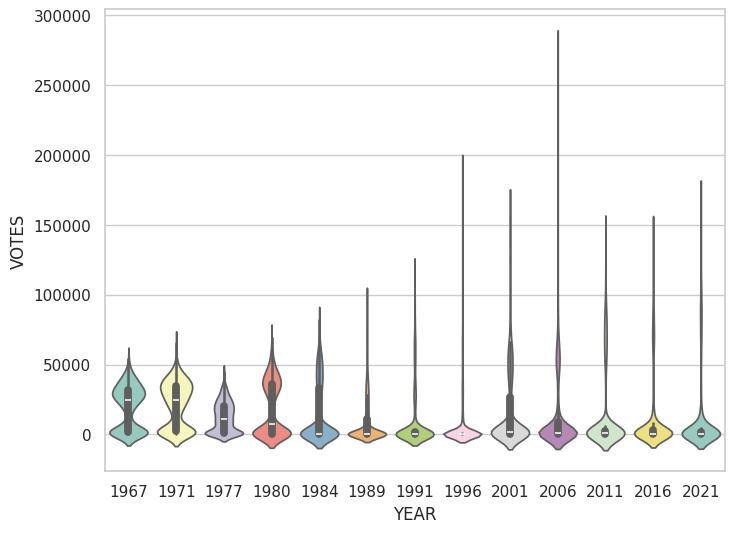

In [9]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.violinplot(x='YEAR', y='VOTES', data=state_df, palette='Set3')
plt.show()

### 2. For the given state, Use a scatter plot to show the correlation between the length of a candidate name (string length) and the votes gathered by the candidate.



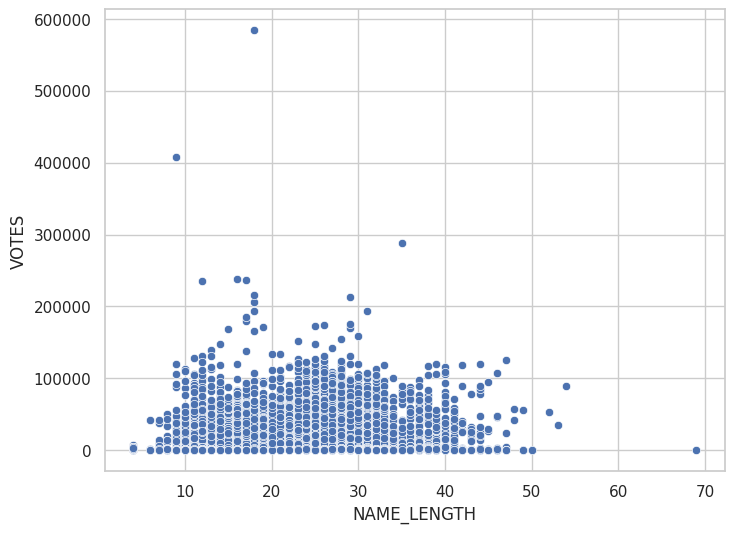

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
state_df['NAME_LENGTH'] = state_df['CANDIDATE'].apply(len)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NAME_LENGTH', y='VOTES', data=state_df)
plt.show()

<ipython-input-13-2b6c3ba17b7a>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='NAME_LENGTH', y='VOTES', data=state_df, color='red', ci=None, label='Trend')


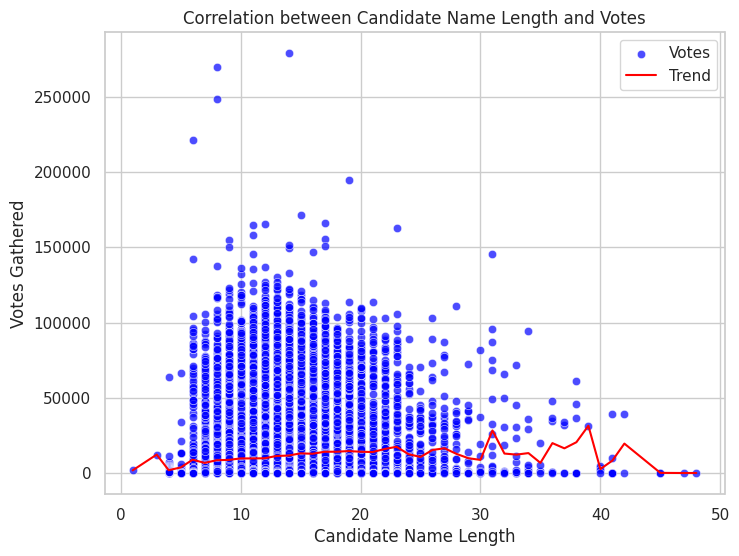

In [13]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
state_df['NAME_LENGTH'] = state_df['CANDIDATE'].apply(len)

plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(x='NAME_LENGTH', y='VOTES', data=state_df, color='blue', alpha=0.7, label='Votes')

# Line plot
sns.lineplot(x='NAME_LENGTH', y='VOTES', data=state_df, color='red', ci=None, label='Trend')

plt.xlabel('Candidate Name Length')
plt.ylabel('Votes Gathered')
plt.title('Correlation between Candidate Name Length and Votes')
plt.legend()
plt.show()

dataset link ="https://22f3001919.github.io/tds_project_1/"